# Notebook to evaluate the loss function results

This notebook is designed as an evaluation notebook.

In [1]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import csv
import time
import os
import ants
import pandas as pd
import statsmodels.api as sm
import numpy as np
from nibabel import load as load_nii
from nibabel import Nifti1Image
from skimage.filters import threshold_otsu
from skimage.measure import label as bwlabeln
from shutil import copyfile
import torch
from torch import nn
from torch.nn import functional as F

plt.rcParams.update({'font.size': 16})

## Statistic functions

In [44]:
def get_fold_dict(csv_files, path):
    dicts = []
    keys = []
    for fi, file in enumerate(csv_files):
        print(' '.join([' '] * 100), end='\r')
        print(
            'Reading CSV file {:} [{:03d}/{:03d}]'.format(
                file, fi + 1, len(csv_files),
            ), end='\r'
        )
        csv_name = os.path.join(path, file)
        with open(csv_name) as csv_file:
            reader = csv.reader(csv_file)
            keys = next(reader)
            results_dict = {}
            for key in keys[1:-1]:
                results_dict[key] = []
            for row in reader:
                for key, data in zip(keys[1:-1], row[1:-1]):
                    results_dict[key].append(float(data))
        dicts.append(results_dict)

    final_dict = {}
    for key in keys[1:-1]:
        metrics = np.stack([filter_nan(metrics[key]) for metrics in dicts], axis=0)
        final_dict['min_' + key] = np.min(metrics, axis=0)
        final_dict['std-_' + key] = np.mean(metrics, axis=0) - np.std(metrics, axis=0)
        final_dict['mean_' + key] = np.mean(metrics, axis=0)
        final_dict['std+_' + key] = np.mean(metrics, axis=0) + np.std(metrics, axis=0)
        final_dict['max_' + key] = np.max(metrics, axis=0)
        final_dict['all_' + key] = metrics
    return final_dict


def filter_nan(data): 
    if np.isnan(data).any():
        new_data = []
        for di, datum in enumerate(data):
            if np.isnan(datum):
                if di == 0:
                        prei = np.where(np.logical_not(np.isnan(data[di:])))[0][0]
                        posti = np.where(np.logical_not(np.isnan(data[di:])))[0][1]
                        new_data.append(
                            (data[posti] * (prei - di) - data[prei] * (posti - di)) / (prei - posti)
                        )
                else:
                    if di == (len(data) - 1):
                        prei = np.where(np.logical_not(np.isnan(data[:di])))[0][-2]
                        posti = np.where(np.logical_not(np.isnan(data[:di])))[0][-1]
                    else:
                        prei = np.where(np.logical_not(np.isnan(data[:di])))[0][-1]
                        posti = np.where(np.logical_not(np.isnan(data[di:])))[0][0] + di
                    new_data.append(
                        (data[posti] - data[prei]) * (di - prei) / (posti - prei) + data[prei]
                    )
            else:
                new_data.append(datum)
        if np.isnan(new_data).any():
            print(data, new_data)
        data = new_data
    
    return data

def get_all_dicts(path):
    files = os.listdir(path)
    
    all_dicts = []
    for i in range(5):
        fold_tag = 'n{:d}'.format(i)
        fold_files = [
            f for f in files
            if fold_tag in f
        ]
        fold_dict = {}
        for loss_tag in loss_tags:
            loss_files = [
                f for f in fold_files
                if '-{:}.'.format(loss_tag) in f and optim_tag in f
                and lr_tag in f and rate_tag in f and f.endswith('.csv')
            ]
            fold_dict[loss_tag] = get_fold_dict(loss_files, path)
        all_dicts.append(fold_dict)
    
    return all_dicts


def get_all_bdicts(path):
    files = os.listdir(path)
    
    all_dicts = []
    for i in range(5):
        fold_tag = 'n{:d}'.format(i)
        fold_files = [
            f for f in files
            if fold_tag in f and 'batch' in f and 'batch-im' not in f
        ]
        fold_dict = {}
        for loss_tag in loss_tags:
            loss_files = [
                f for f in fold_files
                if '-{:}.'.format(loss_tag) in f and optim_tag in f
                and lr_tag in f and rate_tag in f and f.endswith('.csv')
            ]
            fold_dict[loss_tag] = get_fold_dict(loss_files, path)
        all_dicts.append(fold_dict)
    
    return all_dicts


def get_all_bimdicts(path):
    files = os.listdir(path)
    
    all_dicts = []
    for i in range(5):
        fold_tag = 'n{:d}'.format(i)
        fold_files = [
            f for f in files
            if fold_tag in f and 'batch-im' in f
        ]
        fold_dict = {}
        for loss_tag in loss_tags:
            loss_files = [
                f for f in fold_files
                if '-{:}.'.format(loss_tag) in f and optim_tag in f
                and lr_tag in f and rate_tag in f and f.endswith('.csv')
            ]
            fold_dict[loss_tag] = get_fold_dict(loss_files, path)
        all_dicts.append(fold_dict)
    
    return all_dicts


def get_table_vector(all_dicts, losses, names):
    table_vector = []
    latex_array = ''
    for i, (name, loss) in enumerate(zip(names, losses)):
        loss_table = [name]
        latex_dsc = name
        latex_fn = name
        best_fold = []
        for fold_dict in all_dicts:
            best_fold.append([
                np.max(1 - fold_dict[loss]['all_train_dsc'][:, 1:]),
                np.max(1 - fold_dict[loss]['all_val_dsc'][:, 1:]),
                np.max(1 - fold_dict[loss]['all_test_dsc'][:, 1:]),
                np.max(1 - fold_dict[loss]['all_train_fn'][:, 1:]),
                np.max(1 - fold_dict[loss]['all_val_fn'][:, 1:]),
                np.max(1 - fold_dict[loss]['all_test_fn'][:, 1:])
            ])
            fold_metrics = [
                '{:4.2f} [{:4.2f}, {:4.2f}]'.format(
                    np.mean(1 - fold_dict[loss]['all_train_dsc'][:, 1:]),
                    np.min(1 - fold_dict[loss]['all_train_dsc'][:, 1:]),
                    np.max(1 - fold_dict[loss]['all_train_dsc'][:, 1:]),
                    np.std(1 - fold_dict[loss]['all_train_dsc'][:, 1:])
                ),
                '{:4.2f} [{:4.2f}, {:4.2f}]'.format(
                    np.mean(1 - fold_dict[loss]['all_val_dsc'][:, 1:]),
                    np.min(1 - fold_dict[loss]['all_val_dsc'][:, 1:]),
                    np.max(1 - fold_dict[loss]['all_val_dsc'][:, 1:]),
                    np.std(1 - fold_dict[loss]['all_val_dsc'][:, 1:])
                ),
                '{:4.2f} [{:4.2f}, {:4.2f}]'.format(
                    np.mean(1 - fold_dict[loss]['all_test_dsc'][:, 1:]),
                    np.min(1 - fold_dict[loss]['all_test_dsc'][:, 1:]),
                    np.max(1 - fold_dict[loss]['all_test_dsc'][:, 1:]),
                    np.std(1 - fold_dict[loss]['all_test_dsc'][:, 1:])
                ),
                '{:4.2f} [{:4.2f}, {:4.2f}]'.format(
                    np.mean(1 - fold_dict[loss]['all_train_fn'][:, 1:]),
                    np.min(1 - fold_dict[loss]['all_train_fn'][:, 1:]),
                    np.max(1 - fold_dict[loss]['all_train_fn'][:, 1:]),
                    np.std(1 - fold_dict[loss]['all_train_fn'][:, 1:])
                ),
                '{:4.2f} [{:4.2f}, {:4.2f}]'.format(
                    np.mean(1 - fold_dict[loss]['all_val_fn'][:, 1:]),
                    np.min(1 - fold_dict[loss]['all_val_fn'][:, 1:]),
                    np.max(1 - fold_dict[loss]['all_val_fn'][:, 1:]),
                    np.std(1 - fold_dict[loss]['all_val_fn'][:, 1:])
                ),
                '{:4.2f} [{:4.2f}, {:4.2f}]'.format(
                    np.mean(1 - fold_dict[loss]['all_test_fn'][:, 1:]),
                    np.min(1 - fold_dict[loss]['all_test_fn'][:, 1:]),
                    np.max(1 - fold_dict[loss]['all_test_fn'][:, 1:]),
                    np.std(1 - fold_dict[loss]['all_test_fn'][:, 1:])
                ),
            ]
            loss_table += fold_metrics
            latex_dsc +=  ' & {:} '.format(' & '.join(fold_metrics[:3])).replace('±', '$\pm$')
            latex_fn +=  ' & {:} '.format(' & '.join(fold_metrics[3:])).replace('±', '$\pm$')
        best_values = ['{:4.2f}'.format(val) for val in np.mean(best_fold, axis=0)]
        loss_table += best_values
        latex_array += '{:} & {:} \\\\\n'.format(name, ' & '.join(best_values))
        table_vector.append(loss_table)
    return table_vector, latex_array


def violin_analysis(all_dicts):
    plt.ioff()
    figs = []
    for i, fold_dict in enumerate(all_dicts):        
        plt.figure()
        figs.append(plt.gcf().number)

        ax = plt.subplot(2, 2, 1)
        ax.set_title('Training fold {:d} DSC'.format(i))
        plot_violin([1 - v['all_val_dsc'][:, 1:].flatten() for v in fold_dict.values()], names, ax)
        
        ax = plt.subplot(2, 2, 2)
        ax.set_title('Training fold {:d} TP'.format(i))
        plot_violin([1 - v['all_val_fn'][:, 1:].flatten() for v in fold_dict.values()], names, ax)
              
        ax = plt.subplot(2, 2, 3)
        ax.set_title('Testing fold {:d} DSC'.format(i))
        plot_violin([1 - v['all_test_dsc'][:, 1:].flatten() for v in fold_dict.values()], names, ax)
               
        ax = plt.subplot(2, 2, 4)
        ax.set_title('Testing fold {:d} TP'.format(i))
        plot_violin([1 - v['all_test_fn'][:, 1:].flatten() for v in fold_dict.values()], names, ax)
    
    plt.figure()
    figs.append(plt.gcf().number)
    
    ax = plt.subplot(2, 2, 1)
    ax.set_title('All folds training DSC')
    data = np.concatenate([
        [1 - v['all_val_dsc'][1:,:] for v in fold_dict.values()]
        for fold_dict in all_dicts
    ], axis=1)
    plot_violin(data.flatten(), names, ax)
    
    ax = plt.subplot(2, 2, 2)
    ax.set_title('All folds training TP')
    data = np.concatenate([
        [1 - v['all_val_fn'][1:,:] for v in fold_dict.values()]
        for fold_dict in all_dicts
    ], axis=1)
    plot_violin(data.flatten(), names, ax)
      
    ax = plt.subplot(2, 2, 3)
    ax.set_title('All folds testing DSC')
    data = np.concatenate([
        [1 - v['all_test_dsc'][1:,:] for v in fold_dict.values()]
        for fold_dict in all_dicts
    ], axis=1)
    plot_violin(data.flatten(), names, ax)
       
    ax = plt.subplot(2, 2, 4)
    ax.set_title('All folds testing TP')
    data = np.concatenate([
        [1 - v['all_test_fn'][1:,:] for v in fold_dict.values()]
        for fold_dict in all_dicts
    ], axis=1)
    plot_violin(data.flatten(), names, ax)
    
    plt.show()
    return figs


def save_violin_analysis(path, all_dicts, names):
    plt.ioff()
    figs = []
    for i, fold_dict in enumerate(all_dicts):                
        save_violin(
            [1 - v['all_val_dsc'][:, 1:].flatten() for v in fold_dict.values()],
            names, os.path.join(path, 'train_violin_dsc_n{:d}'.format(i)),
            title='Training images fold {:d} DSC'.format(i), names=names
        )
        save_violin(
            [1 - v['all_val_fn'][:, 1:].flatten() for v in fold_dict.values()],
            names, os.path.join(path, 'train_violin_tp_n{:d}'.format(i)),
            title='Training images fold {:d} TPf'.format(i), names=names
        )
        save_violin(
            [1 - v['all_test_dsc'][:, 1:].flatten() for v in fold_dict.values()],
            names, os.path.join(path, 'test_violin_dsc_n{:d}'.format(i)),
            title='Testing images fold {:d} DSC'.format(i), names=names
        )
        save_violin(
            [1 - v['all_test_fn'][:, 1:].flatten() for v in fold_dict.values()],
            names, os.path.join(path, 'test_violin_tp_n{:d}'.format(i)),
            title='Testing images fold {:d} TPf'.format(i), names=names
        )
    data = np.concatenate([
        [1 - v['all_val_dsc'][:, 1:] for v in fold_dict.values()]
        for fold_dict in all_dicts
    ], axis=-1)
    save_violin(
        [datum.flatten() for datum in data],
        names, os.path.join(path, 'train_violin_dsc'),
        title='Training images DSC', names=names
    )
    data = np.concatenate([
        [1 - v['all_val_fn'][:, 1:] for v in fold_dict.values()]
        for fold_dict in all_dicts
    ], axis=-1)
    save_violin(
        [datum.flatten() for datum in data],
        names, os.path.join(path, 'train_violin_tp'),
        title='Training images TPf', names=names
    )
    data = np.concatenate([
        [1 - v['all_test_dsc'][:, 1:] for v in fold_dict.values()]
        for fold_dict in all_dicts
    ], axis=-1)
    save_violin(
        [datum.flatten() for datum in data],
        names, os.path.join(path, 'test_violin_dsc'),
        title='Testing images DSC', names=names
    )
    data = np.concatenate([
        [1 - v['all_test_fn'][:, 1:] for v in fold_dict.values()]
        for fold_dict in all_dicts
    ], axis=-1)
    save_violin(
        [datum.flatten() for datum in data],
        names, os.path.join(path, 'test_violin_tp'),
        title='Testing images TPf', names=names
    )
    
    plt.show()



def band_analysis(all_dicts, names):
    plt.ioff()
    figs = []
    for i, fold_dict in enumerate(all_dicts):        
        plt.figure()
        figs.append(plt.gcf().number)
               
        ax = plt.subplot(2, 3, 1)
        y_dsc = [1 - v['mean_train_dsc'] for v in fold_dict.values()]
        yinf_dsc = [1 - v['min_train_dsc'] for v in fold_dict.values()]
        ysup_dsc = [1 - v['max_train_dsc'] for v in fold_dict.values()]       
        x = range(len(y_dsc[0]))
        plot_bands(
            x, y_dsc, yinf_dsc, ysup_dsc, title='Training patches DSC metric fold n{:d}'.format(i),
            ymin=0, ymax=1, ylabel='DSC metric', legend=names, ax=ax
        )
        
        ax = plt.subplot(2, 3, 2)
        y_dsc = [1 - v['mean_val_dsc'] for v in fold_dict.values()]
        yinf_dsc = [1 - v['min_val_dsc'] for v in fold_dict.values()]
        ysup_dsc = [1 - v['max_val_dsc'] for v in fold_dict.values()]
        plot_bands(
            x, y_dsc, yinf_dsc, ysup_dsc, title='Training images DSC metric fold n{:d}'.format(i),
            ymin=0, ymax=1, ylabel='DSC metric', legend=names, ax=ax
        )
              
        ax = plt.subplot(2, 3, 3)
        y_dsc = [1 - v['mean_test_dsc'] for v in fold_dict.values()]
        yinf_dsc = [1 - v['min_test_dsc'] for v in fold_dict.values()]
        ysup_dsc = [1 - v['max_test_dsc'] for v in fold_dict.values()]
        plot_bands(
            x, y_dsc, yinf_dsc, ysup_dsc, title='Testing images DSC metric fold n{:d}'.format(i),
            ymin=0, ymax=1, ylabel='DSC metric', legend=names, ax=ax
        )
               
        ax = plt.subplot(2, 3, 4)
        y_dsc = [1 - v['mean_train_fn'] for v in fold_dict.values()]
        yinf_dsc = [1 - v['min_train_fn'] for v in fold_dict.values()]
        ysup_dsc = [1 - v['max_train_fn'] for v in fold_dict.values()]       
        plot_bands(
            x, y_dsc, yinf_dsc, ysup_dsc, title='Training patches TP metric fold n{:d}'.format(i),
            ymin=0, ymax=1, ylabel='TP metric', legend=names, ax=ax
        )    
        
        ax = plt.subplot(2, 3, 5)
        y_dsc = [1 - v['mean_val_fn'] for v in fold_dict.values()]
        yinf_dsc = [1 - v['min_val_fn'] for v in fold_dict.values()]
        ysup_dsc = [1 - v['max_val_fn'] for v in fold_dict.values()]
        plot_bands(
            x, y_dsc, yinf_dsc, ysup_dsc, title='Training images TP metric fold n{:d}'.format(i),
            ymin=0, ymax=1, ylabel='TP metric', legend=names, ax=ax
        )

        ax = plt.subplot(2, 3, 6)
        y_dsc = [1 - v['mean_test_fn'] for v in fold_dict.values()]
        yinf_dsc = [1 - v['min_test_fn'] for v in fold_dict.values()]
        ysup_dsc = [1 - v['max_test_fn'] for v in fold_dict.values()]
        plot_bands(
            x, y_dsc, yinf_dsc, ysup_dsc, title='Testing images TP metric fold n{:d}'.format(i),
            ymin=0, ymax=1, ylabel='TP metric', legend=names, ax=ax
        )

    
    plt.figure()
    figs.append(plt.gcf().number)
    plt.show()
    
    return figs


def save_band_analysis(path, all_dicts, names):
    plt.ioff()
    for i, fold_dict in enumerate(all_dicts):    
        data = [1 - v['all_train_dsc'] for v in fold_dict.values()]
        save_all_bands(
            path, data, 'DSC', 'Training patches DSC metric fold n{:d}'.format(i), 'train',
            fold=i, names=names
        )

        data = [1 - v['all_val_dsc'] for v in fold_dict.values()]
        save_all_bands(
            path, data, 'DSC', 'Training images DSC metric fold n{:d}'.format(i), 'val',
            fold=i, names=names
        )

        data = [1 - v['all_test_dsc'] for v in fold_dict.values()]
        save_all_bands(
            path, data, 'DSC', 'Testing images DSC metric fold n{:d}'.format(i), 'test',
            fold=i, names=names
        )

        data = [1 - v['all_train_fn'] for v in fold_dict.values()]
        save_all_bands(
            path, data, 'TP', 'Training patches TPf metric fold n{:d}'.format(i), 'train',
            fold=i, names=names
        )

        data = [1 - v['all_val_fn'] for v in fold_dict.values()]
        save_all_bands(
            path, data, 'TP', 'Training images TPf metric fold n{:d}'.format(i), 'val',
            fold=i, names=names
        )

        data = [1 - v['all_test_fn'] for v in fold_dict.values()]
        save_all_bands(
            path, data, 'TP', 'Testing images TPf metric fold n{:d}'.format(i), 'test',
            fold=i, names=names
        )
        
    min_batches = np.min([v['all_train_dsc'].shape[1] for v in fold_dict.values()])
    data = np.concatenate([
        [1 - v['all_train_dsc'][:, :min_batches] for v in fold_dict.values()]
        for fold_dict in all_dicts
    ], axis=1)
    save_all_bands(path, data, 'DSC', 'Training patches DSC metric', 'train', names=names)
  
    data = np.concatenate([
        [1 - v['all_val_dsc'][:, :min_batches] for v in fold_dict.values()]
        for fold_dict in all_dicts
    ], axis=1)
    save_all_bands(path, data, 'DSC', 'Training images DSC metric', 'val', names=names)
    
    data = np.concatenate([
        [1 - v['all_test_dsc'][:, :min_batches] for v in fold_dict.values()]
        for fold_dict in all_dicts
    ], axis=1)
    save_all_bands(path, data, 'DSC', 'Testing images DSC metric', 'test', names=names)
    
    data = np.concatenate([
        [1 - v['all_train_fn'][:, :min_batches] for v in fold_dict.values()]
        for fold_dict in all_dicts
    ], axis=1)
    save_all_bands(path, data, 'TP', 'Training patches TPf metric', 'train', names=names)
    
    data = np.concatenate([
        [1 - v['all_val_fn'][:, :min_batches] for v in fold_dict.values()]
        for fold_dict in all_dicts
    ], axis=1)
    save_all_bands(path, data, 'TP', 'Training images TPf metric', 'val', names=names)
    
    data = np.concatenate([
        [1 - v['all_test_fn'][:, :min_batches] for v in fold_dict.values()]
        for fold_dict in all_dicts
    ], axis=1)
    save_all_bands(path, data, 'TP', 'Testing images TPf metric', 'test', names=names)
    plt.show()

def plot_violin(data, labels, ax, ymin=0, ymax=1):
    plt.violinplot(data)
    ax.get_xaxis().set_tick_params(direction='out')
#     ax.xaxis.set_ticks_position('bottom')
#     ax.set_xticks(np.arange(1, len(labels) + 1))
#     ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_ylim(ymin=ymin, ymax=ymax)
    plt.xticks(np.arange(1, len(labels) + 1), labels, rotation=45)
    plt.margins(0.3)
    plt.subplots_adjust(bottom=0.15)
    
    
def save_violin(data, labels, file, title='', names=[]):
    plt.ioff()
    fig = plt.figure()
    ax = fig.add_subplot()
    plot_violin(data, names, ax)
    plt.title(title)
    plt.savefig('{:}.png'.format(file), dpi=1200)
    ax.set_rasterized(True)
    plt.savefig('{:}.eps'.format(file))
    plt.close(fig)
    plt.show()

    
def plot_bands(
    x, y, yinf, ysup, ax, xmin=None, xmax=None, ymin=0, ymax=1,
    title='', xlabel='Epoch', ylabel='Metric', legend=None
):
    # Init
    if xmin is None:
        xmin = np.min(x)
    if xmax is None:
        xmax = np.max(x)
    if ymin is None:
        ymin = np.min(yinf)
    if ymax is None:
        ymax = np.max(ysup)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    colomap = ['b', 'g', 'c', 'r', 'm', 'y', 'k']

    if yinf is not None and ysup is not None:
        for yi, yinfi, ysupi, ci in zip(y, yinf, ysup, colomap):
            ax.plot(x, yi, '-', color=ci)
            ax.fill_between(x, yinfi, ysupi, alpha=0.2, color=ci)
    else:
        for yi, ci in zip(y, colomap):
            ax.plot(x, yi, '-', color=ci, linewidth=2.0)

    ax.set_xlim(xmin=xmin, xmax=xmax)
    ax.set_ylim(ymin=ymin, ymax=ymax)

    if legend is not None:
        ax.legend(legend)


def save_all_bands(path, data, metric, title, mode, fold=None, names=[]):
    y = [np.mean(datum, axis=0) for datum in data]
    yinf = [np.min(datum, axis=0) for datum in data]
    ysup = [np.max(datum, axis=0) for datum in data]
    x = range(len(y[0]))
    
    if fold is None:
        file_bands =  os.path.join(path, 'bands_{:}_{:}'.format(metric.lower(), mode))
        file_sbands =  os.path.join(path, 'sbands_{:}_{:}'.format(metric.lower(), mode))
        file_curves =  os.path.join(path, 'curves_{:}_{:}'.format(metric.lower(), mode))
    else:
        file_bands =  os.path.join(path, 'bands_{:}_{:}_n{:d}'.format(metric.lower(), mode, fold))
        file_sbands =  os.path.join(path, 'sbands_{:}_{:}_n{:d}'.format(metric.lower(), mode, fold))
        file_curves =  os.path.join(path, 'curves_{:}_{:}_n{:d}'.format(metric.lower(), mode, fold))
    
    save_bands(
        x, y, yinf, ysup, title=title, ymin=0, ymax=1,
        ylabel='{:} metric'.format(metric.upper()),
        legend=names,file=file_bands
    )
    yinf = [np.mean(datum, axis=0) - np.std(datum, axis=0) for datum in data]
    ysup = [np.mean(datum, axis=0) + np.std(datum, axis=0) for datum in data]
    save_bands(
        x, y, yinf, ysup, title=title, ymin=0, ymax=1,
        ylabel='{:} metric'.format(metric.upper()),
        legend=names, file=file_sbands
    )
    save_bands(
        x, y, None, None, title=title, ymin=0, ymax=1,
        ylabel='{:} metric'.format(metric.upper()),
        legend=names, file=file_curves
    )

        
        
def save_bands(
    x, y, yinf, ysup, file, xmin=None, xmax=None, ymin=0, ymax=1,
    title='', xlabel='Epoch', ylabel='Metric', legend=None
):
    plt.ioff()
    fig = plt.figure()
    ax = fig.add_subplot()
    plot_bands(x, y, yinf, ysup, ax, xmin, xmax, ymin, ymax, title, xlabel, ylabel, legend)
    plt.savefig('{:}.png'.format(file), dpi=1200)
    ax.set_rasterized(True)
    plt.savefig('{:}.eps'.format(file))
    plt.close(fig)
    plt.show()

### Epoch experiments

In [3]:
loss_tags =  ['xent', 'xent_w', 'gdsc_b', 'dsc', 'mixed', 'focal_w2', 'new']
names = ['xent', 'wxent', 'gdsc', 'dsc', 'mixed', 'focal', 'new']
optim_tag = 'adam'

lit_violins = []
lit_bands = []
wmh_violins = []
wmh_bands = []

panda_header = [
    'Loss',
    'Fold1_PatchTrain_DSC', 'Fold1_Train_DSC', 'Fold1_Test_DSC',
    'Fold1_PatchTrain_FN', 'Fold1_Train_FN', 'Fold1_Test_FN',
    'Fold2_PatchTrain_DSC', 'Fold2_Train_DSC', 'Fold2_Test_DSC',
    'Fold2_PatchTrain_FN', 'Fold2_Train_FN', 'Fold2_Test_FN',
    'Fold3_PatchTrain_DSC', 'Fold3_Train_DSC', 'Fold3_Test_DSC',
    'Fold3_PatchTrain_FN', 'Fold3_Train_FN', 'Fold3_Test_FN',
    'Fold4_PatchTrain_DSC', 'Fold4_Train_DSC', 'Fold4_Test_DSC',
    'Fold4_PatchTrain_FN', 'Fold4_Train_FN', 'Fold4_Test_FN',
    'Fold5_PatchTrain_DSC', 'Fold5_Train_DSC', 'Fold5_Test_DSC',
    'Fold5_PatchTrain_FN', 'Fold5_Train_FN', 'Fold5_Test_FN',
    'Mean_PatchTrain_DSC', 'Mean_Train_DSC', 'Mean_Test_DSC',
    'Mean_PatchTrain_FN', 'Mean_Train_FN', 'Mean_Test_FN',
]

### WMH data

#### LR = 1e-4 / NR = 0

In [4]:
wmh_path = '/media/dgx/data/DiceProject/wmh/'
wmh_outpath = '/home/mariano/data/Loss/wmh/lr4nr0/'
lr_tag = '1e-04'
rate_tag = 'nr0'
wmh_dicts = get_all_dicts(wmh_path)

In [5]:
wmh_vector, wmh_latex = get_table_vector(wmh_dicts, loss_tags, names)
pd.DataFrame(wmh_vector, columns=panda_header)

,Loss,Fold1_PatchTrain_DSC,Fold1_Train_DSC,Fold1_Test_DSC,Fold1_PatchTrain_FN,Fold1_Train_FN,Fold1_Test_FN,Fold2_PatchTrain_DSC,Fold2_Train_DSC,Fold2_Test_DSC,...,Fold5_Test_DSC,Fold5_PatchTrain_FN,Fold5_Train_FN,Fold5_Test_FN,Mean_PatchTrain_DSC,Mean_Train_DSC,Mean_Test_DSC,Mean_PatchTrain_FN,Mean_Train_FN,Mean_Test_FN
0,xent,"0.85 [0.45, 0.97]","0.69 [0.52, 0.76]","0.67 [0.53, 0.71]","0.84 [0.39, 0.99]","0.65 [0.42, 0.73]","0.63 [0.43, 0.71]","0.85 [0.43, 0.97]","0.69 [0.52, 0.73]","0.69 [0.50, 0.74]",...,"0.56 [0.35, 0.64]","0.85 [0.42, 0.98]","0.66 [0.41, 0.74]","0.55 [0.26, 0.64]",0.97,0.74,0.72,0.99,0.72,0.71
1,wxent,"0.69 [0.42, 0.87]","0.68 [0.54, 0.73]","0.64 [0.48, 0.70]","0.99 [0.92, 1.00]","0.83 [0.73, 0.93]","0.82 [0.70, 0.94]","0.69 [0.33, 0.87]","0.68 [0.44, 0.74]","0.66 [0.42, 0.72]",...,"0.58 [0.41, 0.65]","0.99 [0.90, 1.00]","0.84 [0.77, 0.97]","0.77 [0.67, 0.94]",0.86,0.74,0.72,1.00,0.96,0.96
2,gdsc,"0.82 [0.61, 0.88]","0.69 [0.51, 0.74]","0.66 [0.49, 0.70]","0.81 [0.56, 0.88]","0.62 [0.41, 0.72]","0.59 [0.39, 0.70]","0.81 [0.63, 0.88]","0.68 [0.55, 0.74]","0.69 [0.54, 0.74]",...,"0.55 [0.45, 0.64]","0.81 [0.58, 0.88]","0.64 [0.46, 0.75]","0.54 [0.35, 0.65]",0.88,0.73,0.72,0.88,0.70,0.70
3,dsc,"0.83 [0.67, 0.89]","0.67 [0.50, 0.72]","0.63 [0.46, 0.69]","0.85 [0.72, 0.91]","0.62 [0.52, 0.71]","0.58 [0.47, 0.69]","0.83 [0.66, 0.89]","0.68 [0.50, 0.73]","0.68 [0.50, 0.72]",...,"0.55 [0.34, 0.67]","0.84 [0.73, 0.90]","0.64 [0.57, 0.73]","0.53 [0.45, 0.64]",0.89,0.73,0.72,0.90,0.70,0.70
4,mixed,"0.84 [0.65, 0.91]","0.69 [0.60, 0.74]","0.65 [0.57, 0.70]","0.85 [0.70, 0.92]","0.62 [0.55, 0.72]","0.58 [0.51, 0.69]","0.84 [0.65, 0.91]","0.70 [0.60, 0.75]","0.70 [0.57, 0.74]",...,"0.58 [0.46, 0.68]","0.85 [0.70, 0.91]","0.64 [0.57, 0.75]","0.53 [0.47, 0.66]",0.91,0.75,0.73,0.92,0.72,0.71
5,focal,"0.87 [0.62, 0.97]","0.73 [0.66, 0.78]","0.70 [0.66, 0.73]","0.92 [0.63, 1.00]","0.71 [0.57, 0.80]","0.69 [0.58, 0.78]","0.87 [0.61, 0.97]","0.73 [0.65, 0.77]","0.72 [0.64, 0.76]",...,"0.61 [0.56, 0.70]","0.93 [0.68, 1.00]","0.73 [0.65, 0.82]","0.63 [0.54, 0.73]",0.97,0.77,0.76,0.99,0.81,0.79
6,new,"0.70 [0.42, 0.89]","0.70 [0.55, 0.75]","0.65 [0.48, 0.71]","0.99 [0.91, 1.00]","0.84 [0.75, 0.95]","0.82 [0.71, 0.96]","0.69 [0.36, 0.87]","0.69 [0.48, 0.75]","0.67 [0.47, 0.73]",...,"0.58 [0.40, 0.66]","0.99 [0.93, 1.00]","0.86 [0.76, 0.96]","0.79 [0.67, 0.94]",0.87,0.75,0.73,1.00,0.97,0.96


In [6]:
print(wmh_latex)

xent & 0.97 & 0.74 & 0.72 & 0.99 & 0.72 & 0.71 \\
wxent & 0.86 & 0.74 & 0.72 & 1.00 & 0.96 & 0.96 \\
gdsc & 0.88 & 0.73 & 0.72 & 0.88 & 0.70 & 0.70 \\
dsc & 0.89 & 0.73 & 0.72 & 0.90 & 0.70 & 0.70 \\
mixed & 0.91 & 0.75 & 0.73 & 0.92 & 0.72 & 0.71 \\
focal & 0.97 & 0.77 & 0.76 & 0.99 & 0.81 & 0.79 \\
new & 0.87 & 0.75 & 0.73 & 1.00 & 0.97 & 0.96 \\



In [7]:
# wmh_violins = violin_analysis(wmh_path, wmh_dicts)
save_violin_analysis(wmh_outpath, wmh_dicts, names)

In [8]:
# wmh_bands = band_analysis(wmh_dicts)
save_band_analysis(wmh_outpath, wmh_dicts, names)

#### LR = 1e-4 / NR = 1

In [45]:
wmh_path = '/media/dgx/data/DiceProject/wmh/'
wmh_outpath = '/home/mariano/data/Loss/wmh/lr4nr1/'
lr_tag = '1e-04'
rate_tag = 'nr1'
wmh_dicts = get_all_dicts(wmh_path)

In [46]:
wmh_vector, wmh_latex = get_table_vector(wmh_dicts, loss_tags, names)
pd.DataFrame(wmh_vector, columns=panda_header)

,Loss,Fold1_PatchTrain_DSC,Fold1_Train_DSC,Fold1_Test_DSC,Fold1_PatchTrain_FN,Fold1_Train_FN,Fold1_Test_FN,Fold2_PatchTrain_DSC,Fold2_Train_DSC,Fold2_Test_DSC,...,Fold5_Test_DSC,Fold5_PatchTrain_FN,Fold5_Train_FN,Fold5_Test_FN,Mean_PatchTrain_DSC,Mean_Train_DSC,Mean_Test_DSC,Mean_PatchTrain_FN,Mean_Train_FN,Mean_Test_FN
0,xent,"0.86 [0.45, 0.98]","0.69 [0.37, 0.75]","0.67 [0.33, 0.72]","0.86 [0.38, 0.99]","0.65 [0.26, 0.73]","0.63 [0.22, 0.72]","0.86 [0.48, 0.98]","0.69 [0.55, 0.73]","0.68 [0.57, 0.72]",...,"0.56 [0.38, 0.67]","0.87 [0.45, 0.98]","0.67 [0.39, 0.76]","0.56 [0.27, 0.69]",0.98,0.74,0.73,0.99,0.73,0.72
1,wxent,"0.59 [0.28, 0.79]","0.68 [0.43, 0.75]","0.64 [0.37, 0.72]","0.99 [0.95, 1.00]","0.87 [0.78, 0.97]","0.85 [0.76, 0.97]","0.58 [0.09, 0.77]","0.67 [0.14, 0.74]","0.65 [0.12, 0.73]",...,"0.56 [0.30, 0.62]","1.00 [0.96, 1.00]","0.87 [0.79, 0.98]","0.81 [0.69, 0.98]",0.77,0.74,0.72,1.00,0.98,0.98
2,gdsc,"0.73 [0.49, 0.81]","0.70 [0.56, 0.76]","0.68 [0.56, 0.72]","0.73 [0.47, 0.82]","0.63 [0.42, 0.71]","0.60 [0.43, 0.71]","0.73 [0.54, 0.81]","0.70 [0.52, 0.75]","0.70 [0.56, 0.75]",...,"0.60 [0.44, 0.70]","0.73 [0.50, 0.85]","0.64 [0.48, 0.74]","0.53 [0.37, 0.65]",0.81,0.76,0.74,0.83,0.73,0.71
3,dsc,"0.76 [0.52, 0.85]","0.67 [0.57, 0.73]","0.64 [0.52, 0.71]","0.84 [0.73, 0.91]","0.61 [0.48, 0.71]","0.58 [0.44, 0.70]","0.76 [0.52, 0.85]","0.68 [0.58, 0.73]","0.68 [0.55, 0.73]",...,"0.55 [0.24, 0.66]","0.84 [0.63, 0.90]","0.64 [0.49, 0.78]","0.53 [0.41, 0.69]",0.85,0.74,0.72,0.90,0.73,0.71
4,mixed,"0.80 [0.59, 0.88]","0.70 [0.59, 0.74]","0.67 [0.56, 0.72]","0.85 [0.64, 0.92]","0.63 [0.52, 0.73]","0.60 [0.48, 0.71]","0.80 [0.57, 0.89]","0.69 [0.55, 0.74]","0.69 [0.54, 0.75]",...,"0.59 [0.45, 0.68]","0.85 [0.63, 0.92]","0.65 [0.51, 0.74]","0.54 [0.41, 0.67]",0.88,0.75,0.74,0.92,0.73,0.72
5,focal,"0.86 [0.60, 0.97]","0.73 [0.68, 0.77]","0.71 [0.67, 0.74]","0.93 [0.64, 0.99]","0.71 [0.61, 0.81]","0.69 [0.61, 0.79]","0.87 [0.48, 0.98]","0.73 [0.52, 0.77]","0.72 [0.53, 0.76]",...,"0.61 [0.53, 0.70]","0.93 [0.66, 1.00]","0.72 [0.63, 0.79]","0.62 [0.51, 0.72]",0.97,0.77,0.76,0.99,0.79,0.78
6,new,"0.61 [0.31, 0.80]","0.70 [0.46, 0.76]","0.65 [0.39, 0.71]","0.99 [0.94, 1.00]","0.86 [0.76, 0.98]","0.84 [0.75, 0.98]","0.58 [0.20, 0.80]","0.68 [0.34, 0.75]","0.66 [0.32, 0.73]",...,"0.58 [0.26, 0.65]","1.00 [0.97, 1.00]","0.87 [0.78, 0.98]","0.81 [0.70, 0.98]",0.81,0.75,0.73,1.00,0.98,0.98


In [47]:
print(wmh_latex)

xent & 0.98 & 0.74 & 0.73 & 0.99 & 0.73 & 0.72 \\
wxent & 0.77 & 0.74 & 0.72 & 1.00 & 0.98 & 0.98 \\
gdsc & 0.81 & 0.76 & 0.74 & 0.83 & 0.73 & 0.71 \\
dsc & 0.85 & 0.74 & 0.72 & 0.90 & 0.73 & 0.71 \\
mixed & 0.88 & 0.75 & 0.74 & 0.92 & 0.73 & 0.72 \\
focal & 0.97 & 0.77 & 0.76 & 0.99 & 0.79 & 0.78 \\
new & 0.81 & 0.75 & 0.73 & 1.00 & 0.98 & 0.98 \\



<IPython.core.display.Javascript object>


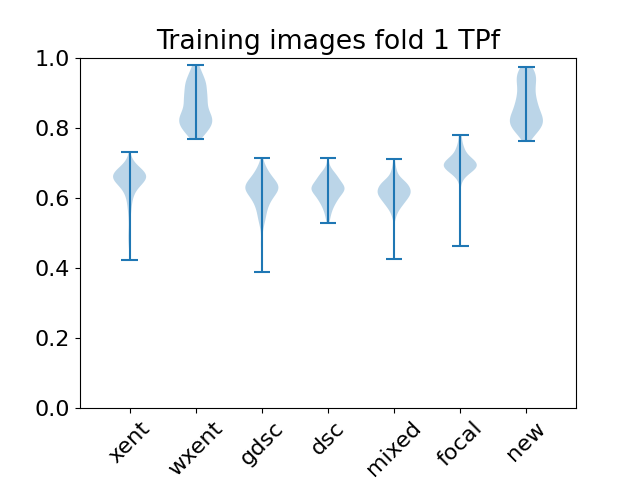

In [48]:
# wmh_violins = violin_analysis(wmh_path, wmh_dicts)
save_violin_analysis(wmh_outpath, wmh_dicts, names)

In [50]:
# wmh_bands = band_analysis(wmh_dicts)
save_band_analysis(wmh_outpath, wmh_dicts, names)

#### LR = 1e-5 / NR = 0

In [51]:
wmh_path = '/media/dgx/data/DiceProject/wmh/'
wmh_outpath = '/home/mariano/data/Loss/wmh/lr5nr0/'
lr_tag = '1e-05'
rate_tag = 'nr0'
wmh_dicts = get_all_dicts(wmh_path)

In [52]:
wmh_vector, wmh_latex = get_table_vector(wmh_dicts, loss_tags, names)
pd.DataFrame(wmh_vector, columns=panda_header)

,Loss,Fold1_PatchTrain_DSC,Fold1_Train_DSC,Fold1_Test_DSC,Fold1_PatchTrain_FN,Fold1_Train_FN,Fold1_Test_FN,Fold2_PatchTrain_DSC,Fold2_Train_DSC,Fold2_Test_DSC,...,Fold5_Test_DSC,Fold5_PatchTrain_FN,Fold5_Train_FN,Fold5_Test_FN,Mean_PatchTrain_DSC,Mean_Train_DSC,Mean_Test_DSC,Mean_PatchTrain_FN,Mean_Train_FN,Mean_Test_FN
0,xent,"0.77 [0.16, 0.95]","0.65 [0.30, 0.73]","0.62 [0.25, 0.68]","0.75 [0.12, 0.96]","0.61 [0.26, 0.71]","0.59 [0.19, 0.69]","0.76 [0.17, 0.95]","0.62 [0.29, 0.69]","0.63 [0.26, 0.69]",...,"0.50 [0.20, 0.57]","0.75 [0.15, 0.96]","0.61 [0.26, 0.71]","0.48 [0.15, 0.61]",0.95,0.70,0.68,0.96,0.68,0.67
1,wxent,"0.67 [0.20, 0.87]","0.64 [0.22, 0.69]","0.60 [0.17, 0.67]","0.99 [0.85, 1.00]","0.79 [0.70, 0.93]","0.77 [0.67, 0.94]","0.66 [0.25, 0.85]","0.65 [0.35, 0.70]","0.64 [0.36, 0.70]",...,"0.53 [0.24, 0.59]","0.99 [0.84, 1.00]","0.82 [0.72, 0.94]","0.73 [0.61, 0.90]",0.86,0.70,0.69,1.00,0.93,0.93
2,gdsc,"0.81 [0.41, 0.90]","0.61 [0.45, 0.68]","0.56 [0.39, 0.64]","0.81 [0.46, 0.89]","0.59 [0.50, 0.73]","0.55 [0.44, 0.72]","0.80 [0.38, 0.89]","0.62 [0.45, 0.67]","0.63 [0.44, 0.69]",...,"0.51 [0.36, 0.57]","0.81 [0.52, 0.89]","0.60 [0.48, 0.73]","0.49 [0.37, 0.66]",0.89,0.67,0.66,0.89,0.71,0.71
3,dsc,"0.84 [0.39, 0.92]","0.61 [0.42, 0.66]","0.56 [0.36, 0.62]","0.88 [0.77, 0.92]","0.58 [0.48, 0.80]","0.54 [0.43, 0.79]","0.83 [0.36, 0.91]","0.62 [0.40, 0.68]","0.61 [0.39, 0.68]",...,"0.52 [0.31, 0.59]","0.88 [0.74, 0.92]","0.60 [0.50, 0.79]","0.50 [0.37, 0.74]",0.91,0.67,0.66,0.92,0.79,0.79
4,mixed,"0.83 [0.43, 0.92]","0.64 [0.44, 0.71]","0.59 [0.38, 0.67]","0.87 [0.56, 0.92]","0.62 [0.53, 0.78]","0.58 [0.49, 0.78]","0.83 [0.39, 0.92]","0.63 [0.43, 0.69]","0.64 [0.43, 0.70]",...,"0.52 [0.35, 0.58]","0.86 [0.60, 0.92]","0.63 [0.56, 0.79]","0.54 [0.45, 0.75]",0.92,0.69,0.68,0.92,0.79,0.78
5,focal,"0.85 [0.44, 0.97]","0.69 [0.52, 0.75]","0.66 [0.54, 0.71]","0.89 [0.45, 0.99]","0.66 [0.48, 0.76]","0.64 [0.49, 0.74]","0.84 [0.42, 0.97]","0.69 [0.51, 0.74]","0.69 [0.51, 0.75]",...,"0.57 [0.41, 0.66]","0.90 [0.47, 0.99]","0.69 [0.55, 0.79]","0.56 [0.40, 0.68]",0.97,0.74,0.73,0.99,0.74,0.73
6,new,"0.69 [0.22, 0.89]","0.66 [0.25, 0.71]","0.62 [0.19, 0.68]","0.99 [0.87, 1.00]","0.81 [0.70, 0.94]","0.78 [0.67, 0.95]","0.68 [0.25, 0.87]","0.66 [0.40, 0.71]","0.66 [0.40, 0.71]",...,"0.55 [0.32, 0.62]","0.99 [0.86, 1.00]","0.82 [0.72, 0.95]","0.73 [0.61, 0.91]",0.89,0.72,0.70,1.00,0.94,0.94


In [53]:
print(wmh_latex)

xent & 0.95 & 0.70 & 0.68 & 0.96 & 0.68 & 0.67 \\
wxent & 0.86 & 0.70 & 0.69 & 1.00 & 0.93 & 0.93 \\
gdsc & 0.89 & 0.67 & 0.66 & 0.89 & 0.71 & 0.71 \\
dsc & 0.91 & 0.67 & 0.66 & 0.92 & 0.79 & 0.79 \\
mixed & 0.92 & 0.69 & 0.68 & 0.92 & 0.79 & 0.78 \\
focal & 0.97 & 0.74 & 0.73 & 0.99 & 0.74 & 0.73 \\
new & 0.89 & 0.72 & 0.70 & 1.00 & 0.94 & 0.94 \\



In [54]:
# wmh_violins = violin_analysis(wmh_path, wmh_dicts)
save_violin_analysis(wmh_outpath, wmh_dicts, names)

In [55]:
# wmh_bands = band_analysis(wmh_dicts)
save_band_analysis(wmh_outpath, wmh_dicts, names)

#### LR = 1e-5 / NR = 1

In [56]:
wmh_path = '/media/dgx/data/DiceProject/wmh/'
wmh_outpath = '/home/mariano/data/Loss/wmh/lr5nr1/'
lr_tag = '1e-05'
rate_tag = 'nr1'
wmh_dicts = get_all_dicts(wmh_path)

In [57]:
wmh_vector, wmh_latex = get_table_vector(wmh_dicts, loss_tags, names)
pd.DataFrame(wmh_vector, columns=panda_header)

,Loss,Fold1_PatchTrain_DSC,Fold1_Train_DSC,Fold1_Test_DSC,Fold1_PatchTrain_FN,Fold1_Train_FN,Fold1_Test_FN,Fold2_PatchTrain_DSC,Fold2_Train_DSC,Fold2_Test_DSC,...,Fold5_Test_DSC,Fold5_PatchTrain_FN,Fold5_Train_FN,Fold5_Test_FN,Mean_PatchTrain_DSC,Mean_Train_DSC,Mean_Test_DSC,Mean_PatchTrain_FN,Mean_Train_FN,Mean_Test_FN
0,xent,"0.83 [0.21, 0.97]","0.66 [0.35, 0.71]","0.63 [0.30, 0.68]","0.82 [0.17, 0.99]","0.63 [0.26, 0.72]","0.60 [0.23, 0.70]","0.82 [0.13, 0.97]","0.64 [0.23, 0.71]","0.65 [0.19, 0.70]",...,"0.52 [0.18, 0.60]","0.82 [0.19, 0.99]","0.63 [0.25, 0.73]","0.50 [0.13, 0.62]",0.97,0.71,0.69,0.99,0.69,0.68
1,wxent,"0.62 [0.19, 0.84]","0.66 [0.35, 0.71]","0.61 [0.31, 0.67]","0.99 [0.89, 1.00]","0.80 [0.70, 0.95]","0.78 [0.67, 0.94]","0.61 [0.16, 0.85]","0.66 [0.32, 0.72]","0.64 [0.32, 0.71]",...,"0.54 [0.20, 0.60]","1.00 [0.92, 1.00]","0.83 [0.73, 0.96]","0.75 [0.64, 0.94]",0.83,0.71,0.70,1.00,0.95,0.95
2,gdsc,"0.77 [0.36, 0.87]","0.63 [0.46, 0.69]","0.59 [0.42, 0.65]","0.77 [0.38, 0.86]","0.59 [0.45, 0.72]","0.56 [0.42, 0.71]","0.77 [0.35, 0.87]","0.64 [0.46, 0.69]","0.64 [0.47, 0.70]",...,"0.53 [0.37, 0.62]","0.77 [0.45, 0.87]","0.60 [0.48, 0.70]","0.50 [0.36, 0.64]",0.86,0.70,0.69,0.86,0.68,0.67
3,dsc,"0.79 [0.29, 0.87]","0.63 [0.47, 0.67]","0.59 [0.41, 0.63]","0.88 [0.77, 0.92]","0.58 [0.46, 0.77]","0.54 [0.41, 0.76]","0.78 [0.23, 0.88]","0.64 [0.44, 0.68]","0.64 [0.44, 0.69]",...,"0.53 [0.35, 0.61]","0.87 [0.76, 0.93]","0.59 [0.50, 0.81]","0.49 [0.39, 0.75]",0.87,0.68,0.68,0.92,0.77,0.76
4,mixed,"0.81 [0.41, 0.89]","0.64 [0.48, 0.69]","0.60 [0.42, 0.66]","0.87 [0.57, 0.92]","0.60 [0.52, 0.75]","0.57 [0.48, 0.75]","0.80 [0.41, 0.89]","0.64 [0.47, 0.69]","0.65 [0.46, 0.71]",...,"0.53 [0.38, 0.61]","0.87 [0.61, 0.92]","0.63 [0.53, 0.77]","0.53 [0.43, 0.75]",0.89,0.69,0.69,0.92,0.76,0.77
5,focal,"0.87 [0.46, 0.98]","0.70 [0.52, 0.76]","0.67 [0.55, 0.71]","0.92 [0.47, 1.00]","0.66 [0.44, 0.75]","0.64 [0.46, 0.74]","0.86 [0.41, 0.98]","0.70 [0.49, 0.74]","0.70 [0.49, 0.74]",...,"0.58 [0.41, 0.66]","0.92 [0.51, 1.00]","0.68 [0.54, 0.79]","0.57 [0.39, 0.67]",0.98,0.75,0.73,1.00,0.74,0.72
6,new,"0.64 [0.20, 0.86]","0.67 [0.38, 0.72]","0.63 [0.33, 0.69]","0.99 [0.91, 1.00]","0.81 [0.72, 0.96]","0.80 [0.69, 0.96]","0.63 [0.17, 0.87]","0.67 [0.36, 0.73]","0.66 [0.36, 0.73]",...,"0.57 [0.22, 0.63]","1.00 [0.93, 1.00]","0.83 [0.73, 0.97]","0.75 [0.62, 0.95]",0.85,0.72,0.71,1.00,0.96,0.96


In [58]:
print(wmh_latex)

xent & 0.97 & 0.71 & 0.69 & 0.99 & 0.69 & 0.68 \\
wxent & 0.83 & 0.71 & 0.70 & 1.00 & 0.95 & 0.95 \\
gdsc & 0.86 & 0.70 & 0.69 & 0.86 & 0.68 & 0.67 \\
dsc & 0.87 & 0.68 & 0.68 & 0.92 & 0.77 & 0.76 \\
mixed & 0.89 & 0.69 & 0.69 & 0.92 & 0.76 & 0.77 \\
focal & 0.98 & 0.75 & 0.73 & 1.00 & 0.74 & 0.72 \\
new & 0.85 & 0.72 & 0.71 & 1.00 & 0.96 & 0.96 \\



In [59]:
# wmh_violins = violin_analysis(wmh_path, wmh_dicts)
save_violin_analysis(wmh_outpath, wmh_dicts, names)

In [60]:
# wmh_bands = band_analysis(wmh_dicts)
save_band_analysis(wmh_outpath, wmh_dicts, names)

### Batch data

In [61]:
batch_path = '/media/dgx/data/DiceProject/longitudinal/'
batch_outpath = '/home/mariano/data/Loss/batch/patch/'
lr_tag = '1e-04'
rate_tag = 'nr0'
batch_dicts = get_all_bdicts(batch_path)

In [62]:
batch_vector, batch_latex = get_table_vector(batch_dicts, loss_tags, names)
pd.DataFrame(batch_vector, columns=panda_header)

,Loss,Fold1_PatchTrain_DSC,Fold1_Train_DSC,Fold1_Test_DSC,Fold1_PatchTrain_FN,Fold1_Train_FN,Fold1_Test_FN,Fold2_PatchTrain_DSC,Fold2_Train_DSC,Fold2_Test_DSC,...,Fold5_Test_DSC,Fold5_PatchTrain_FN,Fold5_Train_FN,Fold5_Test_FN,Mean_PatchTrain_DSC,Mean_Train_DSC,Mean_Test_DSC,Mean_PatchTrain_FN,Mean_Train_FN,Mean_Test_FN
0,xent,"0.30 [0.00, 0.61]","0.35 [0.00, 0.58]","0.27 [0.00, 0.48]","0.26 [0.00, 0.63]","0.28 [0.00, 0.61]","0.23 [0.00, 0.54]","0.29 [0.00, 0.57]","0.33 [0.00, 0.52]","0.31 [0.00, 0.53]",...,"0.29 [0.00, 0.61]","0.19 [0.00, 0.52]","0.17 [0.00, 0.63]","0.22 [0.00, 0.74]",0.57,0.55,0.52,0.60,0.65,0.62
1,wxent,"0.43 [0.01, 0.69]","0.37 [0.00, 0.57]","0.28 [0.00, 0.46]","0.97 [0.47, 1.00]","0.82 [0.45, 0.98]","0.72 [0.35, 0.99]","0.42 [0.01, 0.69]","0.34 [0.00, 0.58]","0.35 [0.00, 0.58]",...,"0.52 [0.01, 0.65]","0.97 [0.47, 1.00]","0.78 [0.35, 0.98]","0.79 [0.44, 0.98]",0.67,0.57,0.52,1.00,0.98,0.99
2,gdsc,"0.65 [0.01, 0.85]","0.48 [0.00, 0.57]","0.32 [0.00, 0.47]","0.76 [0.08, 0.91]","0.57 [0.01, 0.84]","0.48 [0.00, 0.91]","0.64 [0.01, 0.85]","0.47 [0.00, 0.57]","0.45 [0.00, 0.54]",...,"0.55 [0.00, 0.63]","0.72 [0.01, 0.92]","0.51 [0.00, 0.83]","0.54 [0.00, 0.88]",0.86,0.56,0.54,0.92,0.88,0.92
3,dsc,"0.68 [0.01, 0.88]","0.45 [0.00, 0.55]","0.28 [0.00, 0.41]","0.89 [0.28, 0.97]","0.64 [0.33, 0.98]","0.55 [0.21, 1.00]","0.67 [0.01, 0.89]","0.45 [0.00, 0.59]","0.41 [0.00, 0.58]",...,"0.56 [0.01, 0.65]","0.87 [0.22, 0.98]","0.56 [0.19, 0.93]","0.57 [0.27, 0.92]",0.89,0.56,0.53,0.97,0.97,0.98
4,mixed,"0.63 [0.00, 0.86]","0.46 [0.00, 0.59]","0.30 [0.00, 0.47]","0.78 [0.00, 0.95]","0.63 [0.00, 0.88]","0.53 [0.00, 0.90]","0.61 [0.00, 0.86]","0.44 [0.00, 0.59]","0.45 [0.00, 0.61]",...,"0.54 [0.00, 0.65]","0.74 [0.00, 0.96]","0.59 [0.00, 0.88]","0.58 [0.00, 0.86]",0.85,0.59,0.56,0.95,0.88,0.84
5,focal,"0.58 [0.00, 0.83]","0.55 [0.00, 0.64]","0.42 [0.00, 0.53]","0.62 [0.00, 0.92]","0.53 [0.00, 0.77]","0.47 [0.00, 0.67]","0.58 [0.00, 0.81]","0.51 [0.00, 0.62]","0.48 [0.00, 0.64]",...,"0.53 [0.00, 0.70]","0.56 [0.00, 0.90]","0.44 [0.00, 0.74]","0.47 [0.00, 0.76]",0.81,0.62,0.59,0.93,0.78,0.72
6,new,"0.46 [0.01, 0.74]","0.39 [0.00, 0.61]","0.31 [0.00, 0.49]","0.97 [0.49, 1.00]","0.83 [0.42, 0.99]","0.73 [0.44, 0.98]","0.45 [0.01, 0.72]","0.40 [0.00, 0.61]","0.41 [0.00, 0.61]",...,"0.56 [0.01, 0.70]","0.97 [0.45, 1.00]","0.81 [0.34, 0.99]","0.81 [0.31, 0.98]",0.72,0.61,0.56,1.00,0.99,0.98


In [63]:
print(batch_latex)

xent & 0.57 & 0.55 & 0.52 & 0.60 & 0.65 & 0.62 \\
wxent & 0.67 & 0.57 & 0.52 & 1.00 & 0.98 & 0.99 \\
gdsc & 0.86 & 0.56 & 0.54 & 0.92 & 0.88 & 0.92 \\
dsc & 0.89 & 0.56 & 0.53 & 0.97 & 0.97 & 0.98 \\
mixed & 0.85 & 0.59 & 0.56 & 0.95 & 0.88 & 0.84 \\
focal & 0.81 & 0.62 & 0.59 & 0.93 & 0.78 & 0.72 \\
new & 0.72 & 0.61 & 0.56 & 1.00 & 0.99 & 0.98 \\



In [64]:
# lit_violins = violin_analysis(lit_dicts)
save_violin_analysis(batch_outpath, batch_dicts, names)

In [65]:
# lit_bands = band_analysis(lit_path, lit_dicts)
save_band_analysis(batch_outpath, batch_dicts, names)

### Batch image data

In [66]:
batch_path = '/media/dgx/data/DiceProject/longitudinal/'
batch_outpath = '/home/mariano/data/Loss/batch/im/'
lr_tag = '1e-04'
rate_tag = 'nr0'
imbatch_dicts = get_all_bimdicts(batch_path)

In [67]:
batch_vector, batch_latex = get_table_vector(imbatch_dicts, loss_tags, names)
pd.DataFrame(batch_vector, columns=panda_header)

,Loss,Fold1_PatchTrain_DSC,Fold1_Train_DSC,Fold1_Test_DSC,Fold1_PatchTrain_FN,Fold1_Train_FN,Fold1_Test_FN,Fold2_PatchTrain_DSC,Fold2_Train_DSC,Fold2_Test_DSC,...,Fold5_Test_DSC,Fold5_PatchTrain_FN,Fold5_Train_FN,Fold5_Test_FN,Mean_PatchTrain_DSC,Mean_Train_DSC,Mean_Test_DSC,Mean_PatchTrain_FN,Mean_Train_FN,Mean_Test_FN
0,xent,"0.33 [0.00, 0.62]","0.33 [0.00, 0.62]","0.22 [0.00, 0.46]","0.29 [0.00, 0.68]","0.29 [0.00, 0.68]","0.20 [0.00, 0.55]","0.32 [0.00, 0.68]","0.32 [0.00, 0.68]","0.27 [0.00, 0.54]",...,"0.27 [0.00, 0.56]","0.25 [0.00, 0.69]","0.25 [0.00, 0.69]","0.21 [0.00, 0.57]",0.64,0.64,0.48,0.71,0.71,0.55
1,wxent,"0.23 [0.00, 0.38]","0.23 [0.00, 0.38]","0.14 [0.00, 0.25]","0.99 [0.49, 1.00]","0.99 [0.49, 1.00]","0.82 [0.44, 1.00]","0.22 [0.00, 0.38]","0.22 [0.00, 0.38]","0.21 [0.00, 0.38]",...,"0.36 [0.01, 0.52]","0.99 [0.59, 1.00]","0.99 [0.59, 1.00]","0.87 [0.60, 1.00]",0.37,0.37,0.33,1.00,1.00,1.00
2,gdsc,"0.58 [0.00, 0.87]","0.58 [0.00, 0.87]","0.33 [0.00, 0.49]","0.82 [0.00, 0.96]","0.82 [0.00, 0.96]","0.60 [0.00, 0.87]","0.56 [0.00, 0.89]","0.56 [0.00, 0.89]","0.44 [0.00, 0.59]",...,"0.51 [0.00, 0.62]","0.75 [0.00, 0.91]","0.75 [0.00, 0.91]","0.54 [0.00, 0.90]",0.88,0.88,0.55,0.96,0.96,0.88
3,dsc,"0.55 [0.00, 0.86]","0.55 [0.00, 0.86]","0.30 [0.00, 0.50]","0.89 [0.25, 0.99]","0.89 [0.25, 0.99]","0.66 [0.16, 1.00]","0.52 [0.00, 0.90]","0.52 [0.00, 0.90]","0.42 [0.00, 0.62]",...,"0.51 [0.01, 0.64]","0.85 [0.23, 0.98]","0.85 [0.23, 0.98]","0.62 [0.15, 0.95]",0.88,0.88,0.55,0.99,0.99,0.99
4,mixed,"0.49 [0.00, 0.82]","0.49 [0.00, 0.82]","0.30 [0.00, 0.48]","0.74 [0.00, 0.96]","0.74 [0.00, 0.96]","0.58 [0.00, 0.84]","0.49 [0.00, 0.88]","0.49 [0.00, 0.88]","0.40 [0.00, 0.58]",...,"0.47 [0.00, 0.63]","0.70 [0.00, 0.96]","0.70 [0.00, 0.96]","0.52 [0.00, 0.88]",0.84,0.84,0.53,0.97,0.97,0.86
5,focal,"0.56 [0.00, 0.76]","0.56 [0.00, 0.76]","0.38 [0.00, 0.57]","0.63 [0.00, 0.92]","0.63 [0.00, 0.92]","0.44 [0.00, 0.70]","0.57 [0.00, 0.80]","0.57 [0.00, 0.80]","0.47 [0.00, 0.62]",...,"0.49 [0.00, 0.64]","0.61 [0.00, 0.94]","0.61 [0.00, 0.94]","0.46 [0.00, 0.75]",0.78,0.78,0.57,0.94,0.94,0.70
6,new,"0.23 [0.00, 0.39]","0.23 [0.00, 0.39]","0.14 [0.00, 0.26]","0.99 [0.43, 1.00]","0.99 [0.43, 1.00]","0.82 [0.36, 0.99]","0.23 [0.00, 0.43]","0.23 [0.00, 0.43]","0.24 [0.00, 0.48]",...,"0.37 [0.01, 0.63]","0.98 [0.38, 1.00]","0.98 [0.38, 1.00]","0.89 [0.27, 0.99]",0.41,0.41,0.37,1.00,1.00,1.00


In [68]:
print(batch_latex)

xent & 0.64 & 0.64 & 0.48 & 0.71 & 0.71 & 0.55 \\
wxent & 0.37 & 0.37 & 0.33 & 1.00 & 1.00 & 1.00 \\
gdsc & 0.88 & 0.88 & 0.55 & 0.96 & 0.96 & 0.88 \\
dsc & 0.88 & 0.88 & 0.55 & 0.99 & 0.99 & 0.99 \\
mixed & 0.84 & 0.84 & 0.53 & 0.97 & 0.97 & 0.86 \\
focal & 0.78 & 0.78 & 0.57 & 0.94 & 0.94 & 0.70 \\
new & 0.41 & 0.41 & 0.37 & 1.00 & 1.00 & 1.00 \\



In [69]:
# lit_violins = violin_analysis(lit_dicts)
save_violin_analysis(batch_outpath, imbatch_dicts, names)

In [70]:
# lit_bands = band_analysis(lit_path, lit_dicts)
save_band_analysis(batch_outpath, imbatch_dicts, names)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 1301 and the array at index 2 has size 1401

In [ ]:
print(batch_dicts, imbatch_dicts)